# Loading code metrics

First we will load class and method level code metrics from the csv files for each repository.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm

In [2]:
# Load the data
collected_metrics = {}
for project_name in tqdm(os.listdir('CollectedMetrics')):
    class_metrics = None
    method_metrics = None
    try:
        for file in glob(f'CollectedMetrics/{project_name}/*.csv'):
            df = pd.read_csv(file)
            df['project'] = project_name
            if file.endswith('Class.csv'):
                class_metrics = df
            elif file.endswith('Method.csv'):
                method_metrics = df
            else:
                raise Exception('Unknown file type')
            collected_metrics[project_name] = (class_metrics, method_metrics)
    except Exception as e:
        print(f'Error in {project_name}: {e}')

100%|██████████| 118/118 [00:03<00:00, 38.38it/s]


In [3]:
projects = list(collected_metrics.keys())

In [4]:
collected_metrics[projects[0]][0].head()

ID              Name                                   LongName Parent  \
0   L142        ActionMods        AssistantComputerControl.ActionMods   L104   
1   L486   SoftwareUpdater   AssistantComputerControl.SoftwareUpdater   L104   
2   L375     ActionChecker     AssistantComputerControl.ActionChecker   L104   
3  L1037           Actions           AssistantComputerControl.Actions   L104   
4  L1528  AdvancedSettings  AssistantComputerControl.AdvancedSettings   L104   

  Component                                               Path  Line  Column  \
0      L103  D:\DataCollection\repos\AlbertMN_AssistantComp...    22       5   
1      L103  D:\DataCollection\repos\AlbertMN_AssistantComp...    20       5   
2      L103  D:\DataCollection\repos\AlbertMN_AssistantComp...    21       5   
3      L103  D:\DataCollection\repos\AlbertMN_AssistantComp...    22       5   
4      L103  D:\DataCollection\repos\AlbertMN_AssistantComp...     9       5   

   EndLine  EndColumn  ...  WarningMinor  Anti Pattern  Clone Metric Rules  \
0      345          6  ...             0             3                   0   
1      237          6  ...             0             1                   0   
2      616          6  ...             0             4                   0   
3     1202          6  ...             0            11                  16   
4       77          6  ...             0             1                  10   

   Cohesion Metric Rules  Complexity Metric Rules  Coupling Metric Rules  \
0                      0                        3                      0   
1                      1                        1                      1   
2                      2                        4                      2   
3                      1                       11                      0   
4                      1                        0                      0   

   Documentation Metric Rules  Inheritance Metric Rules  Size Metric Rules  \
0                           1                         0                  4   
1                           1                         0                  2   
2                           5                         0                 10   
3                           1                         0                  9   
4                           1                         0                  3   

                             project  
0  AlbertMN_AssistantComputerControl  
1  AlbertMN_AssistantComputerControl  
2  AlbertMN_AssistantComputerControl  
3  AlbertMN_AssistantComputerControl  
4  AlbertMN_AssistantComputerControl  

[5 rows x 84 columns]

Now we need to select only several class and method level code metrics, which we determined in the analysis of the code metrics in the previous notebook.

In [5]:
final_metrics_table = pd.read_csv('final_metrics_table.csv')
final_metrics_table.head()

Abbreviation                      Metric name Category  \
0           AD                API Documentation    Class   
1          CBO  Coupling Between Object classes    Class   
2           CC                   Clone Coverage    Class   
3         CLOC            Comment Lines of Code    Class   
4          DIT        Depth of Inheritance Tree    Class   

                                         Description  
0  Ratio of the number of documented public metho...  
1  Number of directly used other classes (e.g. by...  
2  Ratio of code covered by code duplications in ...  
3  Number of comment and documentation code lines...  
4  Length of the path that leads from the class t...

In [6]:
class_metrics = final_metrics_table[final_metrics_table['Category'] == 'Class']['Abbreviation'].values
method_metrics = final_metrics_table[final_metrics_table['Category'] == 'Method']['Abbreviation'].values

In [7]:
for project_name in collected_metrics.keys():
    class_metrics_df = collected_metrics[project_name][0]
    method_metrics_df = collected_metrics[project_name][1]
    class_metrics_df = class_metrics_df[class_metrics]
    method_metrics_df = method_metrics_df[method_metrics]
    collected_metrics[project_name] = (class_metrics_df, method_metrics_df)

In [8]:
collected_metrics[projects[0]][0].head()

AD  CBO        CC  CLOC  DIT  DLOC  LCOM5  LLDC  LLOC   LOC  ...  \
0  0.500000    2  0.000000    36    0     5      1     0   253   324  ...   
1  0.000000    5  0.000000    15    0     0      2     0   176   218  ...   
2  0.222222    9  0.000000    35    0     2      3     0   456   559  ...   
3  0.078947    6  0.044637    78    0     6      2    64  1004  1179  ...   
4  0.000000    3  0.246429    48    0     8      3     0   172   224  ...   

   TNG  TNLG  TNLM  TNLPM  TNLS  TNM  TNOS  TNPM  TNS  WMC  
0    0     0     7      3     0    7   144     3    0   79  
1    0     0     5      3     0    5   118     3    0   44  
2    1     1    13     10     0   13   282    10    0  123  
3    0     0    46     37     0   46   548    37    0  268  
4    0     0     6      1     0    6   130     1    0   12  

[5 rows x 40 columns]

# Cost functions

We want to find the best subset of code metrics, such that the structure of the repository is preserved. We can use the following non-linear cost functions:
 - Sammon's error function
 - Kruskal's stress function

To use these functions, we need to define a distance function between two points in the metric space. We can use the Euclidean distance for this purpose.
Then we need to find the best subset of code metrics, such that the cost function is minimized. To do it, we will use 2 optimization algorithms:
 - Genetic algorithm
 - Particle swarm optimization (PSO)

To use these algorithms, we need to define a parameter vector, which will be optimized. This vector will have values between 0 and 1, which will be used to select the code metrics. The top $k$ code metrics will be selected, where $k$ is a hyperparameter. After selecting the code metrics, we can calculate the cost function, this will be the fitness function for the optimization algorithms.

## Sammon's error function

Sammon's error function measures the ratio between the distance in the original space and the distance in the reduced space. The goal is to minimize this ratio. We will use the version without weights, because we don't have any weights for the distances between points.
Sammon's error function is defined as follows:

$$
E = \frac{1}{\sum_{i<j}d_{ij}}\sum_{i<j}\frac{(d_{ij} - \hat{d}_{ij})^2}{d_{ij}}
$$

where $d_{ij}$ is the distance between points $i$ and $j$ in the original space, and $\hat{d}_{ij}$ is the distance between points $i$ and $j$ in the reduced space.

In [9]:
def sammons_error(X, Y):
    N = X.shape[0]
    sum_d = 0
    sum_error = 0

    for i in range(N):
        for j in range(i + 1, N):
            d = np.linalg.norm(X[i] - X[j])
            d_hat = np.linalg.norm(Y[i] - Y[j])

            if d != 0:
                err = ((d - d_hat) ** 2) / d
                sum_error += err
                sum_d += d

    return sum_error / sum_d if sum_d != 0 else 0

However, this implementation is very slow, because it uses for loops. We can use the vectorized implementation, which is much faster. We can also see, that we do not need to recompute the distances between points in the original space, because they are constant.

In [10]:
from scipy.spatial.distance import pdist, squareform

def get_distances(X):
    dist_X = squareform(pdist(X, 'euclidean'))
    return dist_X, np.sum(dist_X), np.sum(dist_X ** 2)

def optimized_sammons_error(dist_X, sum_d, sum_d_squared, Y): # sum_d_squared for compatibility
    dist_Y = squareform(pdist(Y, 'euclidean'))

    with np.errstate(divide='ignore', invalid='ignore'):
        delta = dist_X - dist_Y
        error = np.where(dist_X != 0, (delta ** 2) / dist_X, 0)

    return np.sum(error) / sum_d

### Test Sammon's error function

In [11]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
Y = np.array([[1, 2], [4, 5], [7, 8]])

dist_X, sum_d, sum_d_squared = get_distances(X)
sammons_error(X, Y), optimized_sammons_error(dist_X, sum_d, sum_d_squared, Y)

(0.03367350481121464, 0.03367350481121464)

## Kruskal's stress function

Kruskal's stress function, like Sammon's error function, is another method for evaluating the quality of a multidimensional scaling (MDS) solution. The function measures the discrepancy between distances in the high-dimensional space and distances in the low-dimensional, reduced space. The goal is to minimize this discrepancy, ensuring that the structure in the high-dimensional space is as faithfully represented as possible in the lower-dimensional space.

Kruskal's stress function is defined as:

$$
E = \sqrt{\frac{\sum_{i<j} (d_{ij} - \hat{d}_{ij})^2}{\sum_{i<j} d_{ij}^2}}
$$

Where $d_{ij}$ is the distance between points $i$ and $j$ in the original space, and $\hat{d}_{ij}$ is the distance between points $i$ and $j$ in the reduced space.

We can also remove the square root, because it doesn't affect the optimization algorithms.

In [12]:
def kruskals_stress(X, Y):
    N = X.shape[0]
    sum_d_squared = 0
    sum_stress = 0

    for i in range(N):
        for j in range(i + 1, N):
            d = np.linalg.norm(X[i] - X[j])
            d_hat = np.linalg.norm(Y[i] - Y[j])
            sum_d_squared += d ** 2
            sum_stress += (d - d_hat) ** 2

    return sum_stress / sum_d_squared if sum_d_squared != 0 else 0

However, this implementation is very slow, because it uses for loops. We can use the vectorized implementation, which is much faster. We can also see, that we do not need to recompute the distances between points in the original space, because they are constant.

In [13]:
from scipy.spatial.distance import pdist, squareform

def optimized_kruskals_stress(dist_X, sum_d, sum_d_squared, Y): # sum_d for compatibility
    dist_Y = squareform(pdist(Y, 'euclidean'))

    delta = dist_X - dist_Y
    sum_stress = np.sum(delta ** 2)

    return sum_stress / sum_d_squared if sum_d_squared != 0 else 0

### Test Kruskal's stress function

In [14]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
Y = np.array([[1, 2], [4, 5], [7, 8]])

dist_X, sum_d, sum_d_squared = get_distances(X)
kruskals_stress(X, Y), optimized_kruskals_stress(dist_X, sum_d, sum_d_squared, Y)

(0.033673504811214644, 0.033673504811214644)

## Fitness function

Now we will define the fitness function, which will be used by the optimization algorithms. The fitness function will accept a parameter vector, which will be used to select the code metrics. The top $k$ code metrics will be selected, where $k$ is a hyperparameter. After selecting the code metrics, we can calculate the cost function, this will be the fitness function for the optimization algorithms.

We will also use caching to speed up the fitness function. We will cache the fitness function for each subset of code metrics, so that we don't need to recompute the cost function for the same subset of code metrics.

In [68]:
def fitness_function(X, parameter_vector, cost_function, k):
    selected_metrics = X[:, parameter_vector.argsort()[-k:]]
    return cost_function(X, selected_metrics)

def get_fitness_function(X, cost_function, k):
    return lambda parameter_vector: fitness_function(X, parameter_vector, cost_function, k)

def optimized_fitness_function(X, X_dist, sum_d, sum_d_squared, parameter_vector, cost_function, k, cached_fitness_function):
    metrics = tuple(np.sort(parameter_vector.argsort()[-k:]))
    selected_metrics = X[:, metrics]
    if metrics not in cached_fitness_function:
        cached_fitness_function[metrics] = cost_function(X_dist, sum_d, sum_d_squared, selected_metrics)
    return cached_fitness_function[metrics]

def get_optimized_fitness_function(X, cost_function, k):
    dist_X, sum_d, sum_d_squared = get_distances(X)
    cached_fitness_function = {}
    return lambda parameter_vector: optimized_fitness_function(X, dist_X, sum_d, sum_d_squared, parameter_vector, cost_function, k, cached_fitness_function)

### Test fitness function

In [69]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
parameter_vector = np.array([0.7, 0.9, 0.3])
fitness_function(X, parameter_vector, sammons_error, 2), fitness_function(X, parameter_vector, kruskals_stress, 2)

(0.03367350481121464, 0.033673504811214644)

# Optimization algorithms

We will implement 2 optimization algorithms:
 - Genetic algorithm
 - Particle swarm optimization (PSO)

Both algorithms would be implemented in general form, accepting any fitness function

## Particle swarm optimization

Particle Swarm Optimization (PSO) is a computational method that optimizes a problem by iteratively improving a candidate solution with regard to a given measure of quality. It simulates the movements of a flock of birds or school of fish.

PSO Algorithm is defined as follows:
1. **Initialization**: Generate a population (swarm) of random solutions (particles).
2. **Velocity and Position Update:** Each particle updates its velocity based on its own experience and that of its neighbors and then moves to a new position.
3. **Evaluation:** Evaluate the fitness of each particle.
4. **Update Personal and Global Best:** Update each particle's personal best if the current position is better. Similarly, update the global best.
5. **Termination:** Repeat steps 2-4 until a stopping criterion is met (like a maximum number of iterations or a satisfactory fitness level).

Velocity Update Formula is defined as follows:

$$
\mathbf{v}_{i}^{(t+1)} = w \mathbf{v}_{i}^{(t)} + c_1 r_1 (\mathbf{p}_{\text{best},i} - \mathbf{x}_{i}^{(t)}) + c_2 r_2 (\mathbf{g}_{\text{best}} - \mathbf{x}_{i}^{(t)})
$$

Where:
- $\mathbf{v}_{i}^{(t+1)}$ is the new velocity of particle $i$ at iteration $t+1$
- $\mathbf{v}_{i}^{(t)}$ is the current velocity of particle $i$ at iteration $t$
- $\mathbf{x}_{i}^{(t)}$ is the current position of particle $i$ at iteration $t$
- $\mathbf{p}_{\text{best},i}$ is the personal best position of particle $i$
- $\mathbf{g}_{\text{best}}$ is the global best position among all particles
- $w$ is the inertia weight
- $c_1$ and $c_2$ are the cognitive and social parameters, respectively
- $r_1$ and $r_2$ are random numbers between 0 and 1

Position Update Formula is defined as follows:

$$
\mathbf{x}_{i}^{(t+1)} = \mathbf{x}_{i}^{(t)} + \mathbf{v}_{i}^{(t+1)}
$$

Where:
- $\mathbf{x}_{i}^{(t+1)}$ is the new position of particle $i$ at iteration $t+1$
- $\mathbf{x}_{i}^{(t)}$ is the current position of particle $i$ at iteration $t$
- $\mathbf{v}_{i}^{(t+1)}$ is the new velocity of particle $i$ at iteration $t+1$

In [259]:
import numpy as np


def pso(fitness_function, dim, num_particles=30, max_iter=100, bounds=None, w=0.5, c1=0.8, c2=0.9, verbose=False):
    """
    Particle Swarm Optimization (PSO) algorithm.

    Parameters:
    - fitness_function: The fitness function to be optimized.
    - dim: Dimensionality of the search space.
    - num_particles: Number of particles in the swarm.
    - max_iter: Maximum number of iterations.
    - bounds: Bounds for the search space as a tuple (min, max).
    - w: Inertia weight.
    - c1: Cognitive parameter.
    - c2: Social parameter.

    Returns:
    - The best solution found and its fitness.
    """
    # PSO parameters

    # Initialize the swarm
    if bounds:
        min_bound, max_bound = bounds
        particles = min_bound + (max_bound - min_bound) * np.random.rand(num_particles, dim)
    else:
        particles = np.random.rand(num_particles, dim)

    velocity = np.zeros((num_particles, dim))
    personal_best = particles.copy()
    personal_best_scores = np.array([fitness_function(p) for p in personal_best])
    global_best = personal_best[np.argmin(personal_best_scores)]
    global_best_score = min(personal_best_scores)

    # Iterate over max_iter
    for t in tqdm(range(max_iter), disable=not verbose):
        for i in range(num_particles):
            if verbose:
                print(f'Iteration {t + 1}/{max_iter}, particle {i + 1}/{num_particles} ', end='... ')
            # Update velocity
            r1, r2 = np.random.rand(2)
            velocity[i] = w * velocity[i] + c1 * r1 * (personal_best[i] - particles[i]) \
                          + c2 * r2 * (global_best - particles[i])

            # Update particle position
            particles[i] += velocity[i]
            if bounds:
                particles[i] = np.clip(particles[i], min_bound, max_bound)

            # Evaluate particle
            current_fitness = fitness_function(particles[i])

            # Update personal best
            if current_fitness < personal_best_scores[i]:
                personal_best[i] = particles[i].copy()
                personal_best_scores[i] = current_fitness

                # Update global best
                if current_fitness < global_best_score:
                    global_best = particles[i].copy()
                    global_best_score = current_fitness

            if verbose:
                print(f'Best fitness: {global_best_score}')

    return global_best, global_best_score

### Testing with Rastrigin function

The Rastrigin function is a non-convex function used as a performance test problem for optimization algorithms. It is a typical example for testing global optimization algorithms because of its large number of local minima.

The Rastrigin function is defined as follows:

$$
f(\mathbf{x}) = An + \sum_{i=1}^{n} \left[ x_i^2 - A \cos(2 \pi x_i) \right]
$$

where $A$ is a constant, usually $A = 10$, and $n$ is the number of dimensions.

In [260]:
def rastrigin_function(X):
    A = 10
    return A * len(X) + sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in X])

The plot of the Rastrigin function for $n = 2$ is shown below:

In [49]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

X = np.linspace(-5.12, 5.12, 100)
Y = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(X, Y)
Z = rastrigin_function([X, Y])

ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Rastrigin function')
plt.show()

Now we will test the PSO algorithm with the Rastrigin function.

In [45]:
best_solution, best_fitness = pso(rastrigin_function, dim=2, num_particles=30, max_iter=200, bounds=(-5.12, 5.12))
print(f'Best solution: {best_solution}')
print(f'Best fitness: {best_fitness}')

Best solution: [4.50027026e-10 3.47855410e-09]
Best fitness: 0.0


We know that the global minimum of the Rastrigin function is at $f(0, 0) = 0$. We can see that the PSO algorithm found the point very close to the global minimum.

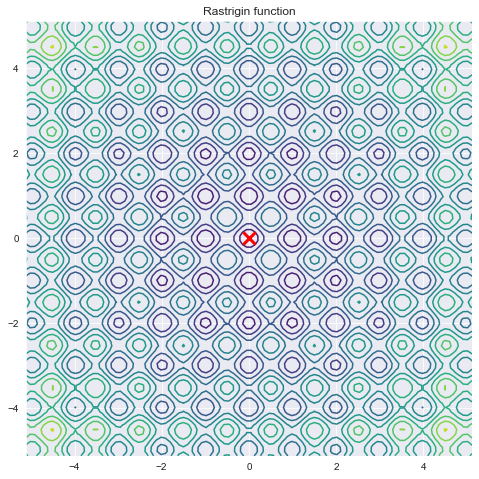

In [51]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()

X = np.linspace(-5.12, 5.12, 100)
Y = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(X, Y)
Z = rastrigin_function([X, Y])

ax.contour(X, Y, Z, 10, cmap='viridis')
ax.scatter(best_solution[0], best_solution[1], color='red', marker='x', s=150, label='Best solution', zorder=10, linewidth=3)
ax.set_title('Rastrigin function')
plt.show()

## Test PSO with Sammon's error function

In [81]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
sammon_error_fitness_function = get_fitness_function(X, sammons_error, 2)
best_solution, best_fitness = pso(sammon_error_fitness_function, dim=X.shape[1], num_particles=30, max_iter=200, bounds=(0, 1))
print(f'Best solution: {best_solution}')
print(f'Best fitness: {best_fitness}')
print(f'Selected metrics: {np.sort(best_solution.argsort()[-2:])}')

Best solution: [0.67024802 0.84155463 0.59194723]
Best fitness: 0.03367350481121464
Selected metrics: [0 1]


## Test PSO with Kruskal's stress function

In [82]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
kruskal_stress_fitness_function = get_fitness_function(X, kruskals_stress, 2)
best_solution, best_fitness = pso(kruskal_stress_fitness_function, dim=X.shape[1], num_particles=30, max_iter=200, bounds=(0, 1))
print(f'Best solution: {best_solution}')
print(f'Best fitness: {best_fitness}')
print(f'Selected metrics: {np.sort(best_solution.argsort()[-2:])}')

Best solution: [0.65931371 0.55072418 0.77645671]
Best fitness: 0.18350341907227408
Selected metrics: [0 2]


## Genetic algorithm

Genetic algorithm is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms. Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems by relying on bio-inspired operators such as mutation, crossover and selection.

Genetic Algorithm is defined as follows:
1. **Initialization:** Generate a population of random solutions (individuals).
2. **Evaluation:** Evaluate the fitness of each individual.
3. **Selection:** Select the best-fit individuals for reproduction. The fitter individuals are more likely to be selected.
4. **Crossover:** With a crossover probability, cross over the parents to form a new offspring (children). If no crossover was performed, offspring is an exact copy of parents.
5. **Mutation:** With a mutation probability, mutate new offspring at each locus (position in chromosome).
6. **Accepting:** Place new offspring in the population.
7. **Termination:** Repeat steps 2-6 until a stopping criterion is met (like a maximum number of iterations or a satisfactory fitness level).

In [261]:
class GeneticAlgorithm:
    def __init__(self, fitness_function, population_size=100, num_features=10, num_generations=50, mutation_rate=0.01, crossover_rate=0.7, mutation_std=0.1, bounds=(0, 1)):
        self.fitness_function = fitness_function
        self.population_size = population_size
        self.num_features = num_features
        self.num_generations = num_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.mutation_std = mutation_std
        self.bounds = bounds
        self.population = np.random.rand(population_size, num_features) * (bounds[1] - bounds[0]) + bounds[0]

    def tournament_selection(self, fitness_scores, tournament_size=3):
        selected = np.random.choice(np.arange(self.population_size), size=tournament_size, replace=False)
        selected_fitness_scores = fitness_scores[selected]
        best_individual = np.argmin(selected_fitness_scores)
        return self.population[selected[best_individual]]

    def single_point_crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            crossover_point = np.random.randint(1, self.num_features)
            child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
            child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
            return child1, child2
        else:
            return parent1, parent2

    def mutate(self, individual):
        for i in range(len(individual)):
            if np.random.rand() < self.mutation_rate:
                individual[i] += np.random.normal(0, self.mutation_std)
                individual[i] = np.clip(individual[i], self.bounds[0], self.bounds[1])
        return individual

    def evolve_population(self):
        new_population = []
        fitness = np.array([self.fitness_function(individual) for individual in self.population])

        for _ in range(self.population_size // 2):
            parent1 = self.tournament_selection(fitness)
            parent2 = self.tournament_selection(fitness)
            child1, child2 = self.single_point_crossover(parent1, parent2)
            new_population.append(self.mutate(child1))
            new_population.append(self.mutate(child2))

        self.population = np.array(new_population)

    def run(self, verbose=False):
        best_fitness = np.inf
        best_individual = None

        for generation in tqdm(range(self.num_generations), disable=not verbose):
            self.evolve_population()
            fitness = np.array([self.fitness_function(individual) for individual in self.population])
            best_idx = np.argmin(fitness)

            if fitness[best_idx] < best_fitness:
                best_fitness = fitness[best_idx]
                best_individual = self.population[best_idx]

        return best_individual, best_fitness

### Test Genetic algorithm with Rastrigin function

In [262]:
ga = GeneticAlgorithm(rastrigin_function, population_size=200, num_features=2, num_generations=2000, mutation_rate=0.1, crossover_rate=0.7, mutation_std=1, bounds=(-5.12, 5.12))
best_solution, best_fitness = ga.run(verbose=True)
print(f'Best solution: {best_solution}')
print(f'Best fitness: {best_fitness}')

100%|██████████| 2000/2000 [00:14<00:00, 137.73it/s]

Best solution: [-2.07087800e-05  3.24652293e-05]
Best fitness: 2.94184651750129e-07


Text(0.5, 1.0, 'Rastrigin function')

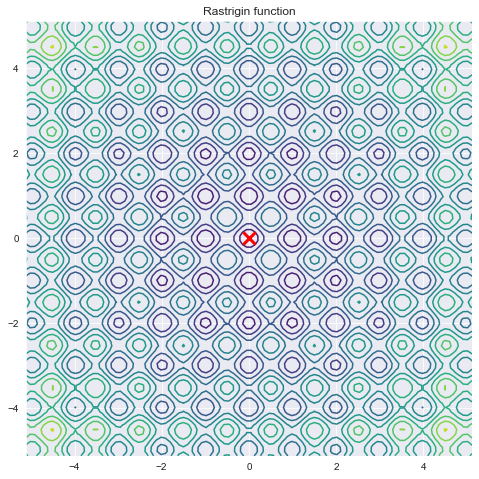

In [263]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()

X = np.linspace(-5.12, 5.12, 100)
Y = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(X, Y)
Z = rastrigin_function([X, Y])

ax.contour(X, Y, Z, 10, cmap='viridis')
ax.scatter(best_solution[0], best_solution[1], color='red', marker='x', s=150, label='Best solution', zorder=10, linewidth=3)
ax.set_title('Rastrigin function')

### Test Genetic algorithm with Sammon's error function

In [161]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
sammon_error_fitness_function = get_fitness_function(X, sammons_error, 2)
ga = GeneticAlgorithm(sammon_error_fitness_function, population_size=200, num_features=X.shape[1], num_generations=100, mutation_rate=0.1, crossover_rate=0.7, mutation_std=0.25, bounds=(0, 1))
best_solution, best_fitness = ga.run(verbose=True)
print(f'Best solution: {best_solution}')
print(f'Best fitness: {best_fitness}')
print(f'Selected metrics: {np.sort(best_solution.argsort()[-2:])}')

100%|██████████| 100/100 [00:02<00:00, 42.80it/s]

Best solution: [0.54157633 0.2184471  0.09740878]
Best fitness: 0.03367350481121464
Selected metrics: [0 1]


### Test Genetic algorithm with Kruskal's stress function

In [187]:
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
kruskal_stress_fitness_function = get_fitness_function(X, kruskals_stress, 2)
ga = GeneticAlgorithm(kruskal_stress_fitness_function, population_size=200, num_features=X.shape[1], num_generations=100, mutation_rate=0.1, crossover_rate=0.7, mutation_std=0.25, bounds=(0, 1))
best_solution, best_fitness = ga.run(verbose=True)
print(f'Best solution: {best_solution}')
print(f'Best fitness: {best_fitness}')
print(f'Selected metrics: {np.sort(best_solution.argsort()[-2:])}')

100%|██████████| 100/100 [00:01<00:00, 55.95it/s]

Best solution: [0.75156843 0.06743263 0.40915637]
Best fitness: 0.033673504811214644
Selected metrics: [0 2]


# Finding the best subset of code metrics

First let's test the PSO algorithm with the Sammon's error function on one repository for k code metrics from 1 to number of code metrics.

We will select the project with the largest number of classes to see the performance of the algorithms.

In [268]:
num_entities = []

for project in collected_metrics.keys():
    num_classes = collected_metrics[project][0].shape[0]
    num_methods = collected_metrics[project][1].shape[0]
    num_entities.append((project, num_classes, num_methods))

num_entities = pd.DataFrame(num_entities, columns=['project', 'num_classes', 'num_methods'])
num_entities.head()

project  num_classes  num_methods
0               AlbertMN_AssistantComputerControl           26          404
1                        aloneguid_parquet-dotnet          263         2515
2                AlturosDestinations_Alturos.Yolo           34          200
3                                 antonpup_Aurora         1004         7175
4  architecture-building-systems_revitpythonshell           41          443

In [269]:
print(f'Project with the largest number of classes: {num_entities.iloc[num_entities["num_classes"].argmax()]["project"]}: {num_entities.iloc[num_entities["num_classes"].argmax()]["num_classes"]}')
print(f'Project with the largest number of methods: {num_entities.iloc[num_entities["num_methods"].argmax()]["project"]} {num_entities.iloc[num_entities["num_methods"].argmax()]["num_methods"]}')

Project with the largest number of classes: bcgit_bc-csharp: 2905
Project with the largest number of methods: dib0_NHapiTools 76673


In [275]:
project_name = num_entities.iloc[num_entities["num_classes"].argmax()]["project"]

We will use step size of 3 for k to reduce the number of iterations.

In [276]:
X = collected_metrics[project_name][0].values
scores_pso = []
for k in tqdm(range(1, X.shape[1] + 1, 3)):
    sammon_error_fitness_function = get_optimized_fitness_function(X, optimized_sammons_error, k)
    best_solution, best_fitness = pso(sammon_error_fitness_function, dim=X.shape[1], num_particles=30, max_iter=30, bounds=(0, 1))
    scores_pso.append(best_fitness)

100%|██████████| 14/14 [04:25<00:00, 18.94s/it]


In [280]:
scores_ga = []
for k in tqdm(range(1, X.shape[1] + 1, 3)):
    sammon_error_fitness_function = get_optimized_fitness_function(X, optimized_sammons_error, k)
    ga = GeneticAlgorithm(sammon_error_fitness_function, population_size=30, num_features=X.shape[1], num_generations=30, mutation_rate=0.1, crossover_rate=0.7, mutation_std=0.25, bounds=(0, 1))
    best_solution, best_fitness = ga.run()
    scores_ga.append(best_fitness)

100%|██████████| 14/14 [18:11<00:00, 77.99s/it] 


Now we will plot the scores for each k.

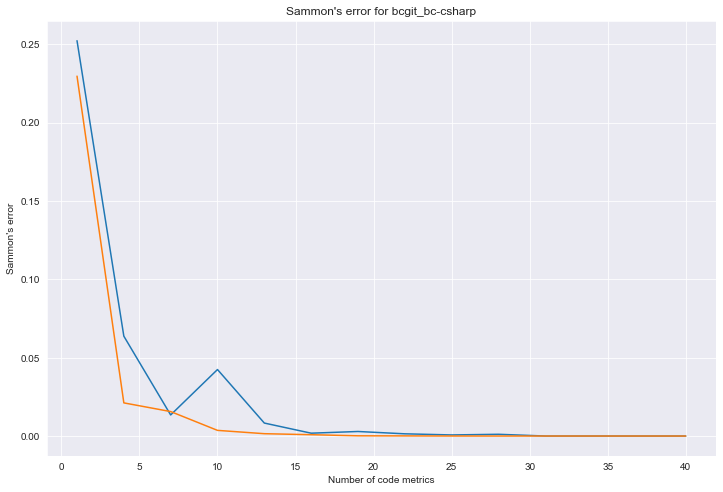

In [281]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, X.shape[1] + 1, 3), scores_pso, label='PSO')
plt.plot(np.arange(1, X.shape[1] + 1, 3), scores_ga, label='GA')
plt.xlabel('Number of code metrics')
plt.ylabel('Sammon\'s error')
plt.title(f'Sammon\'s error for {project_name}')
plt.show()

# Finding the best subset of class metrics for all repositories

To save the results, we will use the following format:
- project_name
- k
- best_solution_pso_sammon
- best_solution_pso_kruskal
- best_fitness_pso_sammon
- best_fitness_pso_kruskal
- best_solution_ga_sammon
- best_solution_ga_kruskal
- best_fitness_ga_sammon
- best_fitness_ga_kruskal

Each repository will be processed 4 times (2 cost functions, 2 optimization algorithms). We will use 8 cores to speed up the process.

In [316]:
from concurrent.futures import ProcessPoolExecutor
from main_task_utils import compute_scores
from itertools import repeat

def process_project(project_name):
    X = collected_metrics[project_name][0].values
    k_values = range(1, X.shape[1] + 1, 2)

    with ProcessPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(compute_scores, repeat(project_name), k_values, repeat(X)))

    return results

def save_table(results):
    df = pd.DataFrame(results, columns=['project_name', 'k', 'best_solution_pso_sammon', 'best_solution_pso_kruskal', 'best_fitness_pso_sammon', 'best_fitness_pso_kruskal', 'best_solution_ga_sammon', 'best_solution_ga_kruskal', 'best_fitness_ga_sammon', 'best_fitness_ga_kruskal'])
    df.to_csv('class_metrics_results.csv', index=False)

    html = df.to_html()
    with open('class_metrics_results.html', 'w') as f:
        f.write(html)

def process_projects(projects):
    results = []
    for project_name in tqdm(projects):
        res = process_project(project_name)
        for r in res:
            results.append((project_name, *r))
        save_table(results)
    return results

In [317]:
process_projects(projects)

100%|██████████| 118/118 [1:58:07<00:00, 60.07s/it]  


[('AlbertMN_AssistantComputerControl',
  2,
  array([0.56257   , 0.41260525, 0.44744112, 0.59925832, 0.55089697,
         0.48945046, 0.3511185 , 0.45438418, 0.53121082, 0.72819636,
         0.5913658 , 0.38600316, 0.35955454, 0.28492223, 0.48428625,
         0.31872409, 0.39041521, 0.61923917, 0.53773738, 0.42565736,
         0.16942937, 0.45369427, 0.72076377, 0.60660839, 0.67250729,
         0.57226273, 0.2925548 , 0.63430614, 0.39910833, 0.76993426,
         0.52806626, 0.440855  , 0.56492803, 0.56423882, 0.55309794,
         0.39517348, 0.48052527, 0.28994724, 0.48866681, 0.6022755 ]),
  array([2.63092245e-01, 6.03771062e-01, 6.84342775e-01, 1.80249454e-01,
         0.00000000e+00, 5.42028258e-01, 7.10022577e-01, 8.03856052e-01,
         7.24732596e-04, 0.00000000e+00, 9.80287876e-01, 7.03631675e-01,
         0.00000000e+00, 6.79846373e-01, 9.23496501e-01, 7.94298107e-01,
         5.90416908e-01, 8.30151198e-01, 7.87373187e-01, 0.00000000e+00,
         0.00000000e+00, 1.11826853e-

# Finding the best subset of method metrics for all repositories

A lot of repositories have more than 4000 methods, so we will use only 4000 randomly selected methods, because the optimization algorithms are very slow.

In [327]:
def get_random_methods(df, num_methods=4000):
    df_n = df.fillna(0)
    if df_n.shape[0] <= num_methods:
        return df_n
    else:
        return df_n.sample(num_methods, random_state=42)

In [331]:
# test
get_random_methods(collected_metrics['dib0_NHapiTools'][1]).shape

(4000, 14)

In [333]:
from concurrent.futures import ProcessPoolExecutor
from main_task_utils import compute_scores
from itertools import repeat

def process_project(project_name):
    X = get_random_methods(collected_metrics[project_name][1]).values
    k_values = range(1, X.shape[1] + 1, 1)

    with ProcessPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(compute_scores, repeat(project_name), k_values, repeat(X)))

    return results

def save_table(results):
    df = pd.DataFrame(results, columns=['project_name', 'k', 'best_solution_pso_sammon', 'best_solution_pso_kruskal', 'best_fitness_pso_sammon', 'best_fitness_pso_kruskal', 'best_solution_ga_sammon', 'best_solution_ga_kruskal', 'best_fitness_ga_sammon', 'best_fitness_ga_kruskal'])
    df.to_csv('method_metrics_results.csv', index=False)

    html = df.to_html()
    with open('method_metrics_results.html', 'w') as f:
        f.write(html)

def process_projects(projects):
    results = []
    for project_name in tqdm(projects):
        res = process_project(project_name)
        for r in res:
            results.append((project_name, *r))
        save_table(results)
    return results

In [334]:
process_projects(projects)

100%|██████████| 118/118 [3:54:06<00:00, 119.04s/it]  


[('AlbertMN_AssistantComputerControl',
  1,
  array([0.33842509, 0.14104911, 0.17035333, 0.81927272, 0.74458489,
         0.78391649, 0.69197152, 0.87405168, 0.90035382, 0.27849838,
         0.32780664, 0.03102124, 0.97386682, 0.65583065]),
  array([0.23145529, 0.81271415, 0.57721486, 0.71921722, 0.83688098,
         0.4478042 , 0.95379216, 0.90746641, 0.38280578, 0.73537624,
         0.5458214 , 0.31561334, 0.96758436, 0.76805167]),
  0.262679323673278,
  0.25472865832788955,
  array([0.35912039, 0.80806554, 0.67479296, 0.56151408, 0.57951271,
         0.38168603, 0.93316418, 0.46554372, 0.6462236 , 0.8545232 ,
         0.89912243, 0.06694601, 0.96977416, 0.16902648]),
  array([0.48678102, 0.92985609, 0.79119693, 0.57478863, 0.53984489,
         0.91793086, 0.17012658, 0.53564774, 0.93830444, 0.77751359,
         0.43372665, 0.96618606, 0.97374037, 0.30248752]),
  0.262679323673278,
  0.25472865832788955),
 ('AlbertMN_AssistantComputerControl',
  2,
  array([0.24405845, 0.10051494, 0.

# Analyzing the results

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
class_metrics_results = pd.read_csv('class_metrics_results.csv')
class_metrics_results = class_metrics_results.replace([np.inf, -np.inf], np.nan)

Let's also take square root of the fitness of the kruskal's stress function, because we were computing it without square root.

In [3]:
class_metrics_results['best_fitness_pso_kruskal'] = np.sqrt(class_metrics_results['best_fitness_pso_kruskal'])
class_metrics_results['best_fitness_ga_kruskal'] = np.sqrt(class_metrics_results['best_fitness_ga_kruskal'])

In [4]:
class_metrics_results.head()

project_name  k  \
0  AlbertMN_AssistantComputerControl  1   
1  AlbertMN_AssistantComputerControl  2   
2  AlbertMN_AssistantComputerControl  3   
3  AlbertMN_AssistantComputerControl  4   
4  AlbertMN_AssistantComputerControl  5   

                            best_solution_pso_sammon  \
0  [0.30184268 0.71259566 0.47909838 0.18215133 0...   
1  [0.56257    0.41260525 0.44744112 0.59925832 0...   
2  [0.67533792 0.53320457 0.47141303 0.08081611 0...   
3  [0.20582572 0.45777056 0.11976711 0.63522413 0...   
4  [0.58407171 0.64901711 0.43288412 0.42125581 0...   

                           best_solution_pso_kruskal  best_fitness_pso_sammon  \
0  [0.53353498 0.70237942 0.77112013 0.96077905 0...                 0.312327   
1  [2.63092245e-01 6.03771062e-01 6.84342775e-01 ...                 0.096674   
2  [0.57725264 0.6406952  0.35128635 0.51142508 0...                 0.117836   
3  [0.74439843 0.36269581 0.64364392 0.4777374  0...                 0.051280   
4  [0.15729195 0.         0.         0.86539103 0...                 0.039125   

   best_fitness_pso_kruskal  \
0                  0.554072   
1                  0.477495   
2                  0.418325   
3                  0.296486   
4                  0.331052   

                             best_solution_ga_sammon  \
0  [0.85906677 0.02970998 0.17407007 0.06994461 0...   
1  [0.87249911 0.65171961 0.42134027 0.05821091 0...   
2  [0.52369778 0.51048628 0.46880887 0.40506316 0...   
3  [0.11391989 0.60649013 0.32785631 0.57786571 0...   
4  [0.1076678  0.79830757 0.54581672 0.39997535 0...   

                            best_solution_ga_kruskal  best_fitness_ga_sammon  \
0  [0.50541908 0.34814961 0.38141376 0.53018564 0...                0.233781   
1  [0.3488852  0.58432847 0.23523724 0.93514499 0...                0.145951   
2  [0.         0.60402126 0.82069364 0.3983824  0...                0.037846   
3  [0.         0.92341608 0.47733755 0.         0...                0.022953   
4  [0.48605504 0.         0.74380065 0.25196669 0...                0.004504   

   best_fitness_ga_kruskal  
0                 0.478107  
1                 0.304327  
2                 0.182149  
3                 0.087155  
4                 0.134028

In [5]:
method_metrics_results = pd.read_csv('method_metrics_results.csv')
method_metrics_results = method_metrics_results.replace([np.inf, -np.inf], np.nan)

method_metrics_results['best_fitness_pso_kruskal'] = np.sqrt(method_metrics_results['best_fitness_pso_kruskal'])
method_metrics_results['best_fitness_ga_kruskal'] = np.sqrt(method_metrics_results['best_fitness_ga_kruskal'])

In [6]:
method_metrics_results.head()

project_name  k  \
0  AlbertMN_AssistantComputerControl  1   
1  AlbertMN_AssistantComputerControl  2   
2  AlbertMN_AssistantComputerControl  3   
3  AlbertMN_AssistantComputerControl  4   
4  AlbertMN_AssistantComputerControl  5   

                            best_solution_pso_sammon  \
0  [0.33842509 0.14104911 0.17035333 0.81927272 0...   
1  [0.24405845 0.10051494 0.29555875 0.44421821 0...   
2  [0.45713932 0.34307434 0.28087097 0.4249893  0...   
3  [0.39230196 0.1981524  0.5124487  0.25918181 0...   
4  [0.33596218 0.30197266 0.5288556  0.41584004 0...   

                           best_solution_pso_kruskal  best_fitness_pso_sammon  \
0  [0.23145529 0.81271415 0.57721486 0.71921722 0...                 0.262679   
1  [0.25510563 0.60142666 0.51712963 0.67581699 0...                 0.113927   
2  [0.35837355 0.45918617 0.55024746 0.58685236 0...                 0.051594   
3  [0.43272354 0.55195326 0.41722024 0.07702634 0...                 0.020183   
4  [0.55372845 0.3853915  0.36491927 0.87423386 0...                 0.009463   

   best_fitness_pso_kruskal  \
0                  0.504707   
1                  0.369975   
2                  0.226123   
3                  0.135135   
4                  0.128577   

                             best_solution_ga_sammon  \
0  [0.35912039 0.80806554 0.67479296 0.56151408 0...   
1  [0.51637246 0.58649209 0.84027136 0.51717506 0...   
2  [0.24636042 0.67486472 0.58991717 0.33521308 0...   
3  [0.70390693 0.4709927  0.85034828 0.24817465 0...   
4  [0.66905065 0.233893   0.04362728 0.33127489 0...   

                            best_solution_ga_kruskal  best_fitness_ga_sammon  \
0  [0.48678102 0.92985609 0.79119693 0.57478863 0...                0.262679   
1  [0.71336564 0.66671921 0.5953382  0.         0...                0.113927   
2  [0.20737732 0.06667511 0.53663301 0.07525715 0...                0.051594   
3  [0.53815309 0.785006   0.57788491 0.57098986 0...                0.020183   
4  [0.         0.17915832 0.29924098 0.29046895 0...                0.009463   

   best_fitness_ga_kruskal  
0                 0.504707  
1                 0.335417  
2                 0.226123  
3                 0.135135  
4                 0.075066

## Split the data into training and validation sets

In [38]:
from sklearn.model_selection import train_test_split

projects_train, projects_val = train_test_split(projects, test_size=0.3, random_state=42)
print(f'Number of projects in training set: {len(projects_train)}')
print(f'Number of projects in validation set: {len(projects_val)}')

Number of projects in training set: 82
Number of projects in validation set: 36


In [39]:
# save the split
with open('projects_train.txt', 'w') as f:
    for project in projects_train:
        f.write(f'{project}\n')

with open('projects_val.txt', 'w') as f:
    for project in projects_val:
        f.write(f'{project}\n')

In [15]:
# load the split
with open('projects_train.txt', 'r') as f:
    projects_train = [line.strip() for line in f.readlines()]

with open('projects_val.txt', 'r') as f:
    projects_val = [line.strip() for line in f.readlines()]

print(f'Number of projects in training set: {len(projects_train)}')
print(f'Number of projects in validation set: {len(projects_val)}')

Number of projects in training set: 82
Number of projects in validation set: 36


In [40]:
class_metrics_results_train = class_metrics_results[class_metrics_results['project_name'].isin(projects_train)]
class_metrics_results_val = class_metrics_results[class_metrics_results['project_name'].isin(projects_val)]

method_metrics_results_train = method_metrics_results[method_metrics_results['project_name'].isin(projects_train)]
method_metrics_results_val = method_metrics_results[method_metrics_results['project_name'].isin(projects_val)]

## Fitness function values plot

We will plot the average, minimum and maximum fitness function values for each k aggregated over all repositories for class and method metrics.

In [41]:
class_values_at_k = class_metrics_results_train.groupby('k').agg({'best_fitness_pso_sammon': ['mean', 'min', 'max'], 'best_fitness_pso_kruskal': ['mean', 'min', 'max'], 'best_fitness_ga_sammon': ['mean', 'min', 'max'], 'best_fitness_ga_kruskal': ['mean', 'min', 'max']})
class_values_at_k.head()

best_fitness_pso_sammon                     best_fitness_pso_kruskal  \
                     mean       min       max                     mean   
k                                                                        
1                0.274509  0.183266  0.643682                 0.490802   
2                0.176237  0.040103  0.444420                 0.384210   
3                0.124015  0.030984  0.270158                 0.323049   
4                0.087911  0.018719  0.216950                 0.276271   
5                0.069208  0.009400  0.225219                 0.215571   

                      best_fitness_ga_sammon                      \
        min       max                   mean       min       max   
k                                                                  
1  0.350521  0.847970               0.251453  0.164177  0.511323   
2  0.195324  0.606340               0.105428  0.031020  0.296675   
3  0.113967  0.486595               0.055017  0.012732  0.203237   
4  0.049480  0.499453               0.031896  0.002891  0.133924   
5  0.038156  0.432499               0.023438  0.001566  0.095521   

  best_fitness_ga_kruskal                      
                     mean       min       max  
k                                              
1                0.471796  0.350521  0.685161  
2                0.285236  0.168568  0.538368  
3                0.182463  0.099418  0.431840  
4                0.127695  0.043827  0.374791  
5                0.086420  0.032127  0.293524

In [42]:
method_values_at_k = method_metrics_results_train.groupby('k').agg({'best_fitness_pso_sammon': ['mean', 'min', 'max'], 'best_fitness_pso_kruskal': ['mean', 'min', 'max'], 'best_fitness_ga_sammon': ['mean', 'min', 'max'], 'best_fitness_ga_kruskal': ['mean', 'min', 'max']})
method_values_at_k.head()

best_fitness_pso_sammon                     best_fitness_pso_kruskal  \
                     mean       min       max                     mean   
k                                                                        
1                0.293522  0.219616  0.384880                 0.511862   
2                0.155795  0.080748  0.260109                 0.351016   
3                0.088228  0.030513  0.166540                 0.253801   
4                0.053018  0.018476  0.112363                 0.170525   
5                0.030869  0.006229  0.070340                 0.128206   

                      best_fitness_ga_sammon                      \
        min       max                   mean       min       max   
k                                                                  
1  0.370626  0.599426               0.292422  0.219616  0.384880   
2  0.181914  0.481641               0.135638  0.080244  0.240437   
3  0.092086  0.381269               0.071647  0.030513  0.138892   
4  0.031821  0.293428               0.038450  0.008953  0.080831   
5  0.033039  0.224258               0.022026  0.005256  0.046938   

  best_fitness_ga_kruskal                      
                     mean       min       max  
k                                              
1                0.511450  0.370626  0.599426  
2                0.322327  0.181914  0.461407  
3                0.214283  0.092086  0.328721  
4                0.135040  0.031821  0.243851  
5                0.090344  0.023764  0.188234

In [43]:
import matplotlib.pyplot as plt

# plot average with a line and min and max with dashed lines and area between them

# set global font size
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1, 2, figsize=(28, 12))

ax[0].plot(class_values_at_k.index, class_values_at_k['best_fitness_pso_sammon']['mean'], label='Average')
ax[0].plot(class_values_at_k.index, class_values_at_k['best_fitness_pso_sammon']['min'], linestyle='dashed', label='Min')
ax[0].plot(class_values_at_k.index, class_values_at_k['best_fitness_pso_sammon']['max'], linestyle='dashed', label='Max')
ax[0].fill_between(class_values_at_k.index, class_values_at_k['best_fitness_pso_sammon']['min'], class_values_at_k['best_fitness_pso_sammon']['max'], alpha=0.1)


ax[0].set_xlabel('Number of code metrics')
ax[0].set_ylabel('Sammon\'s error')
ax[0].set_title('Class metrics - PSO')
ax[0].legend()

ax[1].plot(class_values_at_k.index, class_values_at_k['best_fitness_ga_sammon']['mean'], label='Average')
ax[1].plot(class_values_at_k.index, class_values_at_k['best_fitness_ga_sammon']['min'], linestyle='dashed', label='Min')
ax[1].plot(class_values_at_k.index, class_values_at_k['best_fitness_ga_sammon']['max'], linestyle='dashed', label='Max')
ax[1].fill_between(class_values_at_k.index, class_values_at_k['best_fitness_ga_sammon']['min'], class_values_at_k['best_fitness_ga_sammon']['max'], alpha=0.1)

ax[1].set_xlabel('Number of code metrics')
ax[1].set_ylabel('Sammon\'s error')
ax[1].set_title('Class metrics - GA')
ax[1].legend()

plt.show()

First let's set a style of the plots for a scientific paper.

In [44]:
plt.style.use('seaborn-whitegrid')

plt.rcParams.update({
    'font.size': 16,                    # Larger font size
    'text.usetex': False,                # Use LaTeX to write all text
    'figure.figsize': (7, 5),           # Size of the figures
    'axes.labelsize': 20,               # Size of axis labels
    'axes.titlesize': 20,               # Size of the title
    'xtick.labelsize': 16,              # Size of the x-tick labels
    'ytick.labelsize': 16,              # Size of the y-tick labels
    'legend.fontsize': 16,              # Size of the legend
    'axes.linewidth': 1.5,              # Increase the axis line width
    'lines.linewidth': 2,               # Increase the line width
    'lines.markersize': 8,              # Increase marker size
    'xtick.major.width': 1.5,           # Increase x-tick line width
    'ytick.major.width': 1.5,           # Increase y-tick line width
    'xtick.minor.visible': True,        # Show x minor ticks
    'ytick.minor.visible': True,        # Show y minor ticks
    'grid.linestyle': '--',             # Dashed grid lines
    'grid.alpha': 0.7,                  # Transparency of grid lines
})

Let's do the same, but using q10 and q90 instead of min and max. We will also plot krustal's stress function.

In [45]:
import tikzplotlib

class_values_at_k2 = class_metrics_results_train.groupby('k').agg({'best_fitness_pso_sammon': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_pso_kruskal': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_ga_sammon': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_ga_kruskal': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))]})

fig, ax = plt.subplots(2, 2, figsize=(28, 22))
ax[0][0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_pso_sammon']['mean'], label='Average')
ax[0][0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_pso_sammon']['q10'], linestyle='dashed', label='q10')
ax[0][0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_pso_sammon']['q90'], linestyle='dashed', label='q90')
ax[0][0].fill_between(class_values_at_k2.index, class_values_at_k2['best_fitness_pso_sammon']['q10'], class_values_at_k2['best_fitness_pso_sammon']['q90'], alpha=0.1)
# add 0.01 red dashed line
ax[0][0].plot(class_values_at_k2.index, [0.01] * len(class_values_at_k2.index), linestyle='dashed', color='red', label='0.01')
ax[0][0].set_xlabel('Number of code metrics')
ax[0][0].set_ylabel('Sammon\'s error')
ax[0][0].set_title('Class metrics - PSO')
ax[0][0].legend()

ax[0][1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_ga_sammon']['mean'], label='Average')
ax[0][1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_ga_sammon']['q10'], linestyle='dashed', label='q10')
ax[0][1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_ga_sammon']['q90'], linestyle='dashed', label='q90')
ax[0][1].fill_between(class_values_at_k2.index, class_values_at_k2['best_fitness_ga_sammon']['q10'], class_values_at_k2['best_fitness_ga_sammon']['q90'], alpha=0.1)
ax[0][1].set_xlabel('Number of code metrics')
ax[0][1].set_ylabel('Sammon\'s error')
ax[0][1].set_title('Class metrics - GA')
ax[0][1].legend()

ax[1][0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_pso_kruskal']['mean'], label='Average')
ax[1][0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_pso_kruskal']['q10'], linestyle='dashed', label='q10')
ax[1][0].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_pso_kruskal']['q90'], linestyle='dashed', label='q90')
ax[1][0].fill_between(class_values_at_k2.index, class_values_at_k2['best_fitness_pso_kruskal']['q10'], class_values_at_k2['best_fitness_pso_kruskal']['q90'], alpha=0.1)
ax[1][0].set_xlabel('Number of code metrics')
ax[1][0].set_ylabel('Kruskal\'s stress')
ax[1][0].set_title('Class metrics - PSO')
ax[1][0].legend()

ax[1][1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_ga_kruskal']['mean'], label='Average')
ax[1][1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_ga_kruskal']['q10'], linestyle='dashed', label='q10')
ax[1][1].plot(class_values_at_k2.index, class_values_at_k2['best_fitness_ga_kruskal']['q90'], linestyle='dashed', label='q90')
ax[1][1].fill_between(class_values_at_k2.index, class_values_at_k2['best_fitness_ga_kruskal']['q10'], class_values_at_k2['best_fitness_ga_kruskal']['q90'], alpha=0.1)
ax[1][1].set_xlabel('Number of code metrics')
ax[1][1].set_ylabel('Kruskal\'s stress')
ax[1][1].set_title('Class metrics - GA')
ax[1][1].legend()

ax[0][0].text(-0.1, 0.95, '(a)', transform=ax[0][0].transAxes, size=20, weight='bold')
ax[0][1].text(-0.1, 0.95, '(b)', transform=ax[0][1].transAxes, size=20, weight='bold')
ax[1][0].text(-0.1, 0.95, '(c)', transform=ax[1][0].transAxes, size=20, weight='bold')
ax[1][1].text(-0.1, 0.95, '(d)', transform=ax[1][1].transAxes, size=20, weight='bold')

tikzplotlib.save("class_metrics_results_split.tex")
plt.show()

Now render the same plots for tikz latex.

q10 and q90 are much more stable than min and max.

Now we will plot the same for method metrics using q10 and q90.

In [46]:
method_values_at_k2 = method_metrics_results_train.groupby('k').agg({'best_fitness_pso_sammon': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_pso_kruskal': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_ga_sammon': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))], 'best_fitness_ga_kruskal': ['mean', ('q10', lambda x: x[~np.isnan(x)].quantile(0.1)), ('q90', lambda x: x[~np.isnan(x)].quantile(0.9))]})

fig, ax = plt.subplots(2, 2, figsize=(28, 22))
ax[0][0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_pso_sammon']['mean'], label='Average')
ax[0][0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_pso_sammon']['q10'], linestyle='dashed', label='q10')
ax[0][0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_pso_sammon']['q90'], linestyle='dashed', label='q90')
ax[0][0].fill_between(method_values_at_k2.index, method_values_at_k2['best_fitness_pso_sammon']['q10'], method_values_at_k2['best_fitness_pso_sammon']['q90'], alpha=0.1)
ax[0][0].set_xlabel('Number of code metrics')
ax[0][0].set_ylabel('Sammon\'s error')
ax[0][0].set_title('Method metrics - PSO')
ax[0][0].legend()

ax[0][1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_ga_sammon']['mean'], label='Average')
ax[0][1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_ga_sammon']['q10'], linestyle='dashed', label='q10')
ax[0][1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_ga_sammon']['q90'], linestyle='dashed', label='q90')
ax[0][1].fill_between(method_values_at_k2.index, method_values_at_k2['best_fitness_ga_sammon']['q10'], method_values_at_k2['best_fitness_ga_sammon']['q90'], alpha=0.1)
ax[0][1].set_xlabel('Number of code metrics')
ax[0][1].set_ylabel('Sammon\'s error')
ax[0][1].set_title('Method metrics - GA')
ax[0][1].legend()

ax[1][0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_pso_kruskal']['mean'], label='Average')
ax[1][0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_pso_kruskal']['q10'], linestyle='dashed', label='q10')
ax[1][0].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_pso_kruskal']['q90'], linestyle='dashed', label='q90')
ax[1][0].fill_between(method_values_at_k2.index, method_values_at_k2['best_fitness_pso_kruskal']['q10'], method_values_at_k2['best_fitness_pso_kruskal']['q90'], alpha=0.1)
ax[1][0].set_xlabel('Number of code metrics')
ax[1][0].set_ylabel('Kruskal\'s stress')
ax[1][0].set_title('Method metrics - PSO')
ax[1][0].legend()

ax[1][1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_ga_kruskal']['mean'], label='Average')
ax[1][1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_ga_kruskal']['q10'], linestyle='dashed', label='q10')
ax[1][1].plot(method_values_at_k2.index, method_values_at_k2['best_fitness_ga_kruskal']['q90'], linestyle='dashed', label='q90')
ax[1][1].fill_between(method_values_at_k2.index, method_values_at_k2['best_fitness_ga_kruskal']['q10'], method_values_at_k2['best_fitness_ga_kruskal']['q90'], alpha=0.1)
ax[1][1].set_xlabel('Number of code metrics')
ax[1][1].set_ylabel('Kruskal\'s stress')
ax[1][1].set_title('Method metrics - GA')
ax[1][1].legend()

ax[0][0].text(-0.1, 0.95, '(a)', transform=ax[0][0].transAxes, size=20, weight='bold')
ax[0][1].text(-0.1, 0.95, '(b)', transform=ax[0][1].transAxes, size=20, weight='bold')
ax[1][0].text(-0.1, 0.95, '(c)', transform=ax[1][0].transAxes, size=20, weight='bold')
ax[1][1].text(-0.1, 0.95, '(d)', transform=ax[1][1].transAxes, size=20, weight='bold')

tikzplotlib.save("method_metrics_results_split.tex")
plt.show()

# Vote-counting aggregation

In [47]:
def array_from_string(s):
    return np.fromstring(s[1:-1], dtype=np.float64, sep=' ')

In [48]:
class_metrics_votes_pso = {}
class_metrics_votes_ga = {}
method_metrics_votes_pso = {}
method_metrics_votes_ga = {}
optimal_class_k = 10
optimal_method_k = 6

for project in projects:
    try:
        optimal_class_subset_pso_samon = array_from_string(class_metrics_results_train[(class_metrics_results_train['project_name'] == project) & (class_metrics_results_train['k'] == optimal_class_k)].iloc[0]['best_solution_pso_sammon']).argsort()[-optimal_class_k:]
        optimal_class_subset_pso_kruskal = array_from_string(class_metrics_results_train[(class_metrics_results_train['project_name'] == project) & (class_metrics_results_train['k'] == optimal_class_k)].iloc[0]['best_solution_pso_kruskal']).argsort()[-optimal_class_k:]
        optimal_class_subset_ga_samon = array_from_string(class_metrics_results_train[(class_metrics_results_train['project_name'] == project) & (class_metrics_results_train['k'] == optimal_class_k)].iloc[0]['best_solution_ga_sammon']).argsort()[-optimal_class_k:]
        optimal_class_subset_ga_kruskal = array_from_string(class_metrics_results_train[(class_metrics_results_train['project_name'] == project) & (class_metrics_results_train['k'] == optimal_class_k)].iloc[0]['best_solution_ga_kruskal']).argsort()[-optimal_class_k:]

        optimal_method_subset_pso_samon = array_from_string(method_metrics_results_train[(method_metrics_results_train['project_name'] == project) & (method_metrics_results_train['k'] == optimal_method_k)].iloc[0]['best_solution_pso_sammon']).argsort()[-optimal_method_k:]
        optimal_method_subset_pso_kruskal = array_from_string(method_metrics_results_train[(method_metrics_results_train['project_name'] == project) & (method_metrics_results_train['k'] == optimal_method_k)].iloc[0]['best_solution_pso_kruskal']).argsort()[-optimal_method_k:]
        optimal_method_subset_ga_samon = array_from_string(method_metrics_results_train[(method_metrics_results_train['project_name'] == project) & (method_metrics_results_train['k'] == optimal_method_k)].iloc[0]['best_solution_ga_sammon']).argsort()[-optimal_method_k:]
        optimal_method_subset_ga_kruskal = array_from_string(method_metrics_results_train[(method_metrics_results_train['project_name'] == project) & (method_metrics_results_train['k'] == optimal_method_k)].iloc[0]['best_solution_ga_kruskal']).argsort()[-optimal_method_k:]

        for i in optimal_class_subset_pso_samon:
            if i in class_metrics_votes_pso:
                class_metrics_votes_pso[i] += 1
            else:
                class_metrics_votes_pso[i] = 1

        for i in optimal_class_subset_pso_kruskal:
            if i in class_metrics_votes_pso:
                class_metrics_votes_pso[i] += 1
            else:
                class_metrics_votes_pso[i] = 1

        for i in optimal_class_subset_ga_samon:
            if i in class_metrics_votes_ga:
                class_metrics_votes_ga[i] += 1
            else:
                class_metrics_votes_ga[i] = 1

        for i in optimal_class_subset_ga_kruskal:
            if i in class_metrics_votes_ga:
                class_metrics_votes_ga[i] += 1
            else:
                class_metrics_votes_ga[i] = 1

        for i in optimal_method_subset_pso_samon:
            if i in method_metrics_votes_pso:
                method_metrics_votes_pso[i] += 1
            else:
                method_metrics_votes_pso[i] = 1

        for i in optimal_method_subset_pso_kruskal:
            if i in method_metrics_votes_pso:
                method_metrics_votes_pso[i] += 1
            else:
                method_metrics_votes_pso[i] = 1

        for i in optimal_method_subset_ga_samon:
            if i in method_metrics_votes_ga:
                method_metrics_votes_ga[i] += 1
            else:
                method_metrics_votes_ga[i] = 1

        for i in optimal_method_subset_ga_kruskal:
            if i in method_metrics_votes_ga:
                method_metrics_votes_ga[i] += 1
            else:
                method_metrics_votes_ga[i] = 1
    except:
        print(project)

class_metrics_votes_pso

AlbertMN_AssistantComputerControl
architecture-building-systems_revitpythonshell
bitwarden_mobile
Blecki_dwarfcorp
BlueMystical_EDHM_UI
cadon_ARKStatsExtractor
CobaltWolf_Bluedog-Design-Bureau
d2phap_ImageGlass
DeadlyCrush_DeadlyTrade
digital-standard_ThreeDPoseUnityBarracuda
dotnet_TorchSharp
Doublevil_Houhou-SRS
figormartins_pokemon
GridProtectionAlliance_openPDC
hermitdave_FrequencyWords
ispysoftware_iSpy
jaskie_PlayoutAutomation
lllyasviel_YGOProUnity_V2
lunadream_XWall
machine_machine.specifications
microsoft_sqltoolsservice
ModuleArt_quick-picture-viewer
mperdeck_jsnlog
n00mkrad_cupscale
NotCoffee418_TrinityCreator
PowerPointLabs_PowerPointLabs
saucepleez_taskt
SaviorXTanren_mixer-mixitup
SharpRepository_SharpRepository
Squalr_Squalr
sswelm_KSP-Interstellar-Extended
stefsietz_nn-visualizer
veldrid_veldrid
Visual-Stylecop_Visual-StyleCop
wieslawsoltes_ColorPicker
zgynhqf_Rafy


{5: 37,
 28: 122,
 33: 26,
 8: 121,
 13: 35,
 9: 152,
 19: 20,
 15: 46,
 29: 160,
 0: 13,
 7: 34,
 24: 22,
 32: 48,
 4: 10,
 1: 20,
 34: 14,
 37: 58,
 27: 54,
 21: 74,
 36: 81,
 26: 33,
 22: 42,
 39: 52,
 35: 59,
 23: 16,
 38: 19,
 3: 63,
 10: 20,
 30: 26,
 6: 10,
 2: 5,
 12: 35,
 14: 12,
 16: 10,
 17: 13,
 11: 18,
 25: 28,
 31: 14,
 20: 7,
 18: 11}

Make a sorted bar plot for class metrics.

In [49]:
def get_metric_name(i):
    return collected_metrics[project][0].columns[i]

In [50]:
class_metrics_votes_avg = {get_metric_name(k): (v + class_metrics_votes_ga.get(k, 0)) / 2 for k, v in class_metrics_votes_pso.items()}
class_metrics_votes_avg_sorted = {k: v for k, v in sorted(class_metrics_votes_avg.items(), key=lambda item: item[1], reverse=True)}
class_metrics_votes_avg_sorted

{'TLOC': 159.0,
 'LOC': 154.0,
 'LLOC': 140.5,
 'TLLOC': 138.0,
 'TNOS': 102.5,
 'NOS': 94.5,
 'TNM': 74.5,
 'CLOC': 66.0,
 'TNPM': 62.5,
 'TCLOC': 62.0,
 'NM': 59.0,
 'WMC': 52.0,
 'NPM': 47.0,
 'DLOC': 38.5,
 'TNLM': 36.0,
 'RFC': 35.0,
 'LLDC': 33.0,
 'NLM': 27.0,
 'NLPM': 25.0,
 'TNLPM': 24.5,
 'PUA': 21.0,
 'TNG': 20.0,
 'PDA': 13.0,
 'NG': 13.0,
 'TNS': 12.5,
 'NOI': 12.0,
 'CBO': 12.0,
 'NLG': 11.5,
 'NOD': 11.5,
 'TNLS': 10.0,
 'NOC': 10.0,
 'NS': 9.5,
 'TNLG': 9.0,
 'AD': 8.5,
 'LCOM5': 6.5,
 'NLS': 6.5,
 'NOA': 6.5,
 'NOP': 6.5,
 'DIT': 5.0,
 'CC': 5.0}

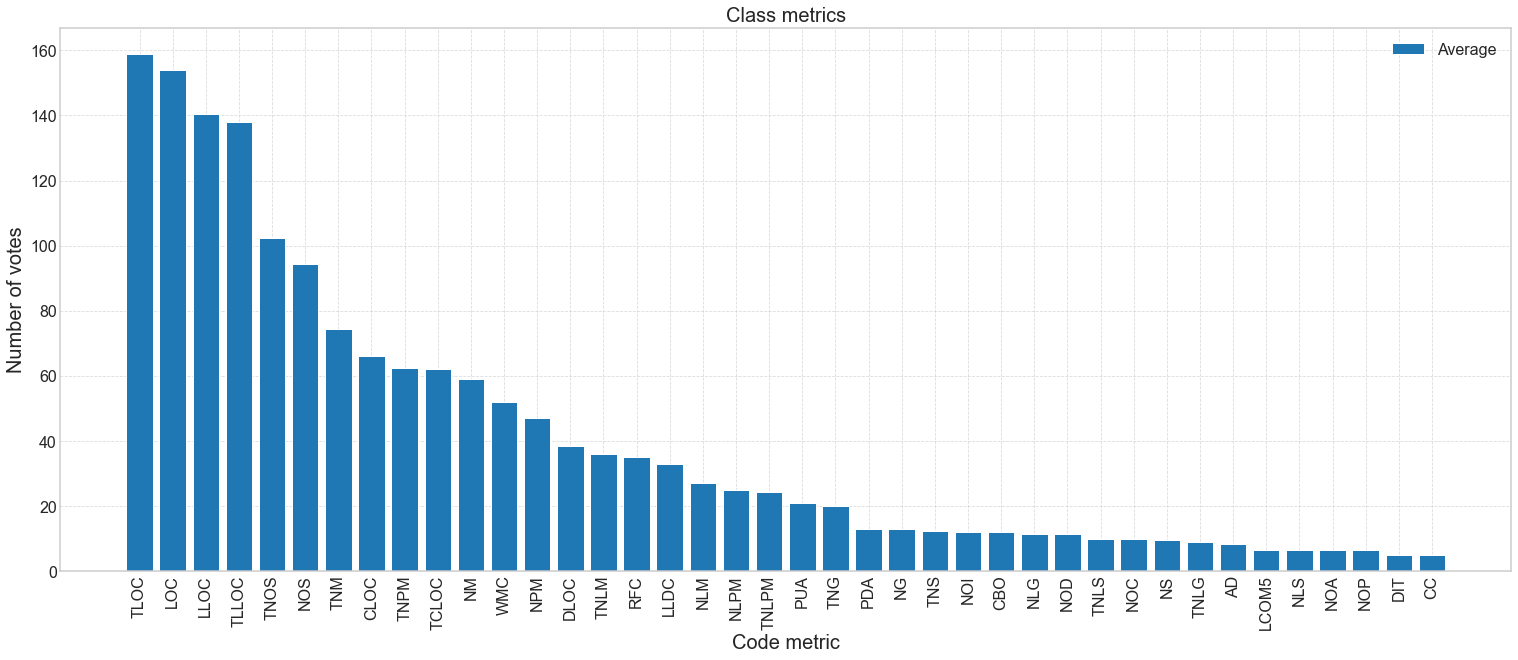

In [51]:
plt.figure(figsize=(26, 10))
plt.bar(class_metrics_votes_avg_sorted.keys(), class_metrics_votes_avg_sorted.values(), label='Average')
plt.xlabel('Code metric')
plt.ylabel('Number of votes')
plt.title('Class metrics')
plt.xticks(rotation=90)
plt.legend()

# setting xticks for tikz
plt.xticks(range(len(class_metrics_votes_avg_sorted.keys())), class_metrics_votes_avg_sorted.keys())

tikzplotlib.save("class_metrics_votes_split.tex")
plt.show()

Optimal subset of class metrics is:

In [57]:
class_optimal_subset = list(class_metrics_votes_avg_sorted.keys())[:optimal_class_k]
class_optimal_subset

['TLOC', 'LOC', 'LLOC', 'TLLOC', 'TNOS', 'NOS', 'TNM', 'CLOC', 'TNPM', 'TCLOC']

In [53]:
def get_method_name(i):
    return collected_metrics[project][1].columns[i]

In [54]:
method_metrics_votes_avg = {get_method_name(k): (v + method_metrics_votes_ga.get(k, 0)) / 2 for k, v in method_metrics_votes_pso.items()}
method_metrics_votes_avg_sorted = {k: v for k, v in sorted(method_metrics_votes_avg.items(), key=lambda item: item[1], reverse=True)}
method_metrics_votes_avg_sorted

{'TLOC': 161.0,
 'LOC': 160.0,
 'TLLOC': 150.5,
 'LLOC': 147.0,
 'TNOS': 89.0,
 'NOS': 81.0,
 'CLOC': 53.0,
 'TCLOC': 50.5,
 'LLDC': 23.5,
 'DLOC': 20.0,
 'NOI': 17.5,
 'NUMPAR': 17.0,
 'McCC': 9.0,
 'CC': 5.0}

In [55]:
plt.figure(figsize=(26, 10))
plt.bar(method_metrics_votes_avg_sorted.keys(), method_metrics_votes_avg_sorted.values(), label='Average')
plt.xlabel('Code metric')
plt.ylabel('Number of votes')
plt.title('Method metrics')
plt.xticks(rotation=90)
plt.legend()

# setting xticks for tikz
plt.xticks(range(len(method_metrics_votes_avg_sorted.keys())), method_metrics_votes_avg_sorted.keys())

tikzplotlib.save("method_metrics_votes_split.tex")
plt.show()

In [58]:
method_optimal_subset = list(method_metrics_votes_avg_sorted.keys())[:optimal_method_k]
method_optimal_subset

['TLOC', 'LOC', 'TLLOC', 'LLOC', 'TNOS', 'NOS']

# Validation

In [16]:
class_optimal_subset = ['TLOC', 'LOC', 'LLOC', 'TLLOC', 'TNOS', 'NOS', 'TNM', 'CLOC', 'TNPM', 'TCLOC']
method_optimal_subset = ['TLOC', 'LOC', 'TLLOC', 'LLOC', 'TNOS', 'NOS']

First we will select the optimal subset of metrics for each project using the validation set.

In [17]:
collected_metrics_val = {}
for project in tqdm(projects_val):
    class_metrics_df = collected_metrics[project][0]
    method_metrics_df = collected_metrics[project][1]
    class_metrics_df = class_metrics_df[class_optimal_subset]
    method_metrics_df = method_metrics_df[method_optimal_subset]
    collected_metrics_val[project] = (class_metrics_df, method_metrics_df)

100%|██████████| 36/36 [00:00<00:00, 1636.34it/s]


In [18]:
collected_metrics_val[projects_val[0]][0].shape, collected_metrics_val[projects_val[0]][1].shape

((660, 10), (1184, 6))

In [19]:
collected_metrics[projects_val[0]][0].shape, collected_metrics[projects_val[0]][1].shape

((660, 40), (1184, 14))

In [20]:
collected_metrics_val[projects_val[0]][0].head()

TLOC  LOC  LLOC  TLLOC  TNOS  NOS  TNM  CLOC  TNPM  TCLOC
0    13   13    11     11     4    4    3     0     3      0
1    16   16    13     13     2    2    4     0     4      0
2    18   18    14     14     0    0    0     0     0      0
3    18   18    14     14     0    0    0     0     0      0
4     6    6     5      5     0    0    0     0     0      0

In [21]:
collected_metrics_val[projects_val[0]][1].head()

TLOC  LOC  TLLOC  LLOC  TNOS  NOS
0     1    1      1     1     0    0
1     1    1      1     1     0    0
2     8    8      7     7     4    4
3     4    4      4     4     1    1
4     4    4      4     4     1    1

In [22]:
collected_metrics_val_full = {}
for project in tqdm(projects_val):
    collected_metrics_val_full[project] = collected_metrics[project]

100%|██████████| 36/36 [00:00<?, ?it/s]


In [23]:
collected_metrics_val_full[projects_val[0]][0].head()

AD  CBO   CC  CLOC  DIT  DLOC  LCOM5  LLDC  LLOC  LOC  ...  TNG  TNLG  \
0  0.0    0  0.0     0    0     0      1     0    11   13  ...    1     1   
1  0.0    1  0.0     0    1     0      2     0    13   16  ...    0     0   
2  0.0    4  0.0     0    1     0      0     0    14   18  ...    0     0   
3  0.0    4  0.0     0    1     0      0     0    14   18  ...    0     0   
4  0.0    1  0.0     0    0     0      0     0     5    6  ...    0     0   

   TNLM  TNLPM  TNLS  TNM  TNOS  TNPM  TNS  WMC  
0     3      3     1    3     4     3    1    4  
1     2      2     0    4     2     4    0    2  
2     0      0     0    0     0     0    0    0  
3     0      0     0    0     0     0    0    0  
4     0      0     0    0     0     0    0    0  

[5 rows x 40 columns]

In [24]:
collected_metrics_val_full[projects_val[0]][0].shape, collected_metrics_val_full[projects_val[0]][1].shape

((660, 40), (1184, 14))

Now we will compute the fitness function values for each project using the optimal subset of metrics.

In [25]:
collected_metrics_val[projects[0]][0].isin([np.inf, -np.inf]).values.any()

False

In [26]:
class_level_validation_results = pd.DataFrame(columns=['project_name', 'sammon', 'kruskal'])
method_level_validation_results = pd.DataFrame(columns=['project_name', 'sammon', 'kruskal'])

In [27]:
for project in tqdm(projects_val):
    class_metrics_df = collected_metrics_val[project][0]
    method_metrics_df = collected_metrics_val[project][1]
    class_metrics_df_full = collected_metrics_val_full[project][0].dropna()
    method_metrics_df_full = collected_metrics_val_full[project][1].dropna()

    method_metrics_df = method_metrics_df.loc[method_metrics_df_full.index].values
    method_metrics_df_full = method_metrics_df_full.values
    class_metrics_df = class_metrics_df.loc[class_metrics_df_full.index].values
    class_metrics_df_full = class_metrics_df_full.values

    class_dist, class_sum_d, class_sum_d_squared = get_distances(class_metrics_df_full)
    method_dist, method_sum_d, method_sum_d_squared = get_distances(method_metrics_df_full)

    class_level_sammon = optimized_sammons_error(class_dist, class_sum_d, class_sum_d_squared, class_metrics_df)
    class_level_kruskal = np.sqrt(optimized_kruskals_stress(class_dist, class_sum_d, class_sum_d_squared, class_metrics_df))

    method_level_sammon = optimized_sammons_error(method_dist, method_sum_d, method_sum_d_squared, method_metrics_df)
    method_level_kruskal = np.sqrt(optimized_kruskals_stress(method_dist, method_sum_d, method_sum_d_squared, method_metrics_df))

    class_level_validation_results = class_level_validation_results.append({'project_name': project, 'sammon': class_level_sammon, 'kruskal': class_level_kruskal}, ignore_index=True)
    method_level_validation_results = method_level_validation_results.append({'project_name': project, 'sammon': method_level_sammon, 'kruskal': method_level_kruskal}, ignore_index=True)

class_level_validation_results.head()

 39%|███▉      | 14/36 [00:39<00:35,  1.63s/it]C:\Users\Threeteck\AppData\Local\Temp\ipykernel_8172\2663252947.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(error) / sum_d
100%|██████████| 36/36 [01:49<00:00,  3.04s/it]


project_name    sammon   kruskal
0                  machine_machine.specifications  0.011871  0.048665
1                     SaviorXTanren_mixer-mixitup  0.016818  0.052724
2  architecture-building-systems_revitpythonshell  0.001515  0.013174
3                        jaskie_PlayoutAutomation  0.012890  0.052608
4       digital-standard_ThreeDPoseUnityBarracuda  0.002686  0.052960

In [31]:
project = 'machine_machine.specifications'
class_metrics_df = collected_metrics_val[project][0]
class_metrics_df_full = collected_metrics_val_full[project][0].dropna()
class_metrics_df = class_metrics_df.loc[class_metrics_df_full.index].values
class_metrics_df_full = class_metrics_df_full.values
class_dist, class_sum_d, class_sum_d_squared = get_distances(class_metrics_df_full)
optimized_sammons = optimized_sammons_error(class_dist, class_sum_d, class_sum_d_squared, class_metrics_df)
optimized_kruskals = np.sqrt(optimized_kruskals_stress(class_dist, class_sum_d, class_sum_d_squared, class_metrics_df))
naive_sammons = sammons_error(class_metrics_df_full, class_metrics_df)
naive_kruskals = np.sqrt(kruskals_stress(class_metrics_df_full, class_metrics_df))

print(optimized_sammons, optimized_kruskals)
print(naive_sammons, naive_kruskals)

0.011870515316409562 0.04866480265195117
0.01187051531641113 0.048664802651949716


In [106]:
# clear memory
import gc
gc.collect()

10588

In [28]:
class_level_validation_results

project_name    sammon   kruskal
0                   machine_machine.specifications  0.011871  0.048665
1                      SaviorXTanren_mixer-mixitup  0.016818  0.052724
2   architecture-building-systems_revitpythonshell  0.001515  0.013174
3                         jaskie_PlayoutAutomation  0.012890  0.052608
4        digital-standard_ThreeDPoseUnityBarracuda  0.002686  0.052960
5                                     zgynhqf_Rafy  0.016681  0.052782
6                                  mperdeck_jsnlog  0.017291  0.083550
7                                 bitwarden_mobile  0.015266  0.050980
8                  SharpRepository_SharpRepository  0.045407  0.195676
9                      NotCoffee418_TrinityCreator  0.025690  0.111298
10                CobaltWolf_Bluedog-Design-Bureau  0.000531  0.011545
11                       wieslawsoltes_ColorPicker  0.005788  0.037720
12                                Blecki_dwarfcorp  0.013104  0.054431
13                sswelm_KSP-Interstellar-Extended  0.015930  0.064627
14                       hermitdave_FrequencyWords       NaN  0.000000
15                            Doublevil_Houhou-SRS  0.005393  0.027807
16                                saucepleez_taskt  0.006629  0.025535
17               AlbertMN_AssistantComputerControl  0.000859  0.015056
18                         stefsietz_nn-visualizer  0.001287  0.018206
19                 Visual-Stylecop_Visual-StyleCop  0.003767  0.017080
20                       microsoft_sqltoolsservice  0.007906  0.033387
21                  GridProtectionAlliance_openPDC  0.005007  0.023118
22                                   Squalr_Squalr  0.004299  0.034317
23                       lllyasviel_YGOProUnity_V2  0.000975  0.007086
24                               ispysoftware_iSpy  0.001221  0.011292
25                            BlueMystical_EDHM_UI  0.002299  0.011389
26                         cadon_ARKStatsExtractor  0.000090  0.007272
27                               n00mkrad_cupscale  0.000428  0.003634
28                                 veldrid_veldrid  0.002781  0.023045
29                         DeadlyCrush_DeadlyTrade  0.012720  0.018177
30                  ModuleArt_quick-picture-viewer  0.002501  0.041016
31                               d2phap_ImageGlass  0.001564  0.012504
32                            figormartins_pokemon  0.028513  0.087309
33                                 lunadream_XWall  0.000611  0.021549
34                   PowerPointLabs_PowerPointLabs  0.003488  0.027178
35                               dotnet_TorchSharp  0.004095  0.018996

In [29]:
method_level_validation_results

project_name    sammon   kruskal
0                   machine_machine.specifications  0.017685  0.057967
1                      SaviorXTanren_mixer-mixitup  0.034943  0.071272
2   architecture-building-systems_revitpythonshell  0.013664  0.045242
3                         jaskie_PlayoutAutomation  0.032570  0.082887
4        digital-standard_ThreeDPoseUnityBarracuda  0.007468  0.071111
5                                     zgynhqf_Rafy  0.049771  0.155585
6                                  mperdeck_jsnlog  0.056273  0.155819
7                                 bitwarden_mobile  0.023946  0.058419
8                  SharpRepository_SharpRepository  0.021600  0.081319
9                      NotCoffee418_TrinityCreator  0.018009  0.047959
10                CobaltWolf_Bluedog-Design-Bureau  0.004072  0.020255
11                       wieslawsoltes_ColorPicker  0.016160  0.061895
12                                Blecki_dwarfcorp  0.017114  0.042270
13                sswelm_KSP-Interstellar-Extended  0.005821  0.038386
14                       hermitdave_FrequencyWords  0.000122  0.003657
15                            Doublevil_Houhou-SRS  0.044733  0.066208
16                                saucepleez_taskt  0.033443  0.163496
17               AlbertMN_AssistantComputerControl  0.004803  0.022922
18                         stefsietz_nn-visualizer  0.022659  0.045255
19                 Visual-Stylecop_Visual-StyleCop  0.087664  0.149133
20                       microsoft_sqltoolsservice  0.043318  0.089517
21                  GridProtectionAlliance_openPDC  0.025878  0.035792
22                                   Squalr_Squalr  0.053519  0.106237
23                       lllyasviel_YGOProUnity_V2  0.002801  0.007265
24                               ispysoftware_iSpy  0.019828  0.046511
25                            BlueMystical_EDHM_UI  0.024894  0.056801
26                         cadon_ARKStatsExtractor  0.013662  0.052393
27                               n00mkrad_cupscale  0.005460  0.045375
28                                 veldrid_veldrid  0.026380  0.055213
29                         DeadlyCrush_DeadlyTrade  0.023715  0.067679
30                  ModuleArt_quick-picture-viewer  0.035022  0.034438
31                               d2phap_ImageGlass  0.026710  0.035684
32                            figormartins_pokemon  0.063701  0.101384
33                                 lunadream_XWall  0.006147  0.013288
34                   PowerPointLabs_PowerPointLabs  0.007098  0.058961
35                               dotnet_TorchSharp  0.065911  0.197676

In [30]:
class_level_validation_results.to_csv('class_level_validation_results.csv', index=False)
method_level_validation_results.to_csv('method_level_validation_results.csv', index=False)

In [ ]:
class_level_validation_results = pd.read_csv('class_level_validation_results.csv')
method_level_validation_results = pd.read_csv('method_level_validation_results.csv')